In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

<class 'pandas.core.frame.DataFrame'>
Index: 2015 entries, 2016-08-24 to 2017-08-23
Data columns (total 1 columns):
prcp    2015 non-null float64
dtypes: float64(1)
memory usage: 31.5+ KB


Text(0, 0.5, 'Rainfall')

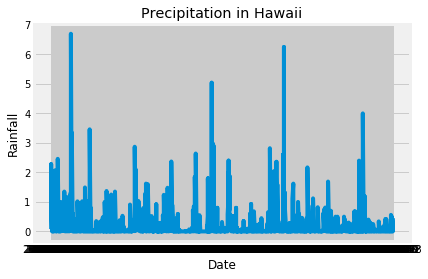

In [163]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_months = session.query(Measurement).order_by(Measurement.date.desc()).limit(1)

for date in last_months:
    fecha = date.date

fecha_reciente = dt.datetime.strptime(fecha, "%Y-%m-%d")

# Calculate the date 1 year ago from the last data point in the database
a_year_ago = fecha_reciente - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_scores = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= a_year_ago).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precipitation_scores).dropna()
df.set_index('date', inplace=True)
df.info()

#print (df)

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(df)
plt.title("Precipitation in Hawaii")
plt.xlabel('Date')
plt.ylabel('Rainfall')


![precipitation](Images/precipitation.png)

In [27]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [29]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).distinct().count()
print(stations)

9


In [60]:
from sqlalchemy import desc

# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station=pd.DataFrame(session.query(Measurement.station, func.count(Measurement.station).label('count')). \
                     group_by(Measurement.station).\
                     order_by(desc('count')).all())

station

,station,count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [61]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
                
session.query(*sel).filter(Measurement.station==station.iloc[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

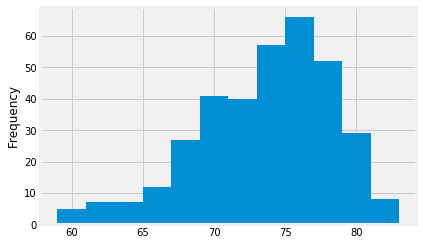

In [63]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_tobs = session.query(Measurement.tobs).\
                                filter(Measurement.station==most_active_station).\
                                filter(Measurement.date >= a_year_ago).\
                                order_by(Measurement.date.desc()).all()

x = [x[0] for x in most_active_tobs]


plt.hist(x, bins=12)
plt.ylabel('Frequency')
plt.show()

![precipitation](Images/station-histogram.png)

In [75]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
#print(calc_temps('2016-01-01', '2016-01-10'))
print(calc_temps('2016-02-28', '2016-03-05'))

[(62.0, 69.88636363636364, 80.0)]


In [66]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = calc_temps('2017-01-01', '2017-01-10')
temps

[(60.0, 68.0327868852459, 77.0)]

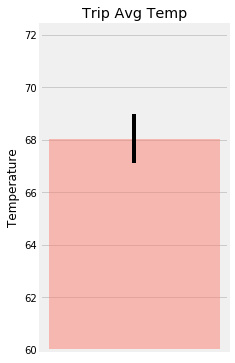

In [70]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
lower = temps[0][1] - temps[0][0]
upper = temps[0][2] - temps[0][1]

plt.figure(figsize=(3,6))
plt.bar(0, temps[0][1], yerr=[upper-lower], color='salmon', alpha=0.5)
plt.title('Trip Avg Temp')
plt.xticks([])
plt.ylabel('Temperature')
plt.ylim(60)

plt.show()

In [74]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(Measurement.station,
                         Station.name,
                         Measurement.prcp,
                         Station.latitude,
                         Station.longitude,
                         Station.elevation).\
                            group_by(Measurement.station).\
                            join(Station, Measurement.station == Station.station).\
                            filter(Measurement.date >= '2016-01-01').\
                            filter(Measurement.date <= '2016-01-10').\
                            order_by(desc('prcp')).all()
rainfall

[('USC00519281',
  'WAIHEE 837.5, HI US',
  0.02,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117', 'KANEOHE 838.1, HI US', 0.01, 21.4234, -157.8015, 14.6),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 0.01, 21.2716, -157.8168, 3.0),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  0.0,
  21.5213,
  -157.8374,
  7.0),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  0.0,
  21.3331,
  -157.8025,
  152.4),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  0.0,
  21.33556,
  -157.71139,
  19.5),
 ('USC00517948', 'PEARL CITY, HI US', None, 21.3934, -157.9751, 11.9)]

## Optional Challenge Assignment

In [108]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

62.0

In [164]:
import datetime

# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
    
    
# Set the start and end date of the trip
start_date = datetime.datetime.strptime('2016-01-01', "%Y-%m-%d")
end_date = start_date + datetime.timedelta(days=10)

start = start_date
delta = datetime.timedelta(days=1)
date_range = []

# Use the start and end date to create a range of dates
print(delta)
while start <= end_date:
    date_range.append(start)
    start += delta
print(date_range)

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

ranges = []
for date in date_range:
    #s_month = date.strftime('%m')
    #s_day = date.strftime('%d')
    #m,mi,av
    algo = daily_normals(func.strftime("%d-%m", date))
    m=algo[0][0]
    mi=algo[0][1]
    av=algo[0][2]

    ranges.append({'tmin':mi, 'tavg':av, 'tmax':m})
#print(ranges)



1 day, 0:00:00
[datetime.datetime(2016, 1, 1, 0, 0), datetime.datetime(2016, 1, 2, 0, 0), datetime.datetime(2016, 1, 3, 0, 0), datetime.datetime(2016, 1, 4, 0, 0), datetime.datetime(2016, 1, 5, 0, 0), datetime.datetime(2016, 1, 6, 0, 0), datetime.datetime(2016, 1, 7, 0, 0), datetime.datetime(2016, 1, 8, 0, 0), datetime.datetime(2016, 1, 9, 0, 0), datetime.datetime(2016, 1, 10, 0, 0), datetime.datetime(2016, 1, 11, 0, 0)]


In [165]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
date_df=pd.DataFrame(ranges,date_range)
date_df.index.names = ['Date']
date_df

,tavg,tmax,tmin
Date,,,
2016-01-01,77.0,62.0,69.153846
2016-01-02,78.0,56.0,68.140351
2016-01-03,76.0,64.0,70.032787
2016-01-04,80.0,60.0,71.879310
2016-01-05,79.0,65.0,72.759259
2016-01-06,81.0,64.0,74.614035
2016-01-07,81.0,67.0,74.777778
2016-01-08,83.0,67.0,75.540000
2016-01-09,82.0,69.0,77.000000


Text(0.5, 0, 'Date')

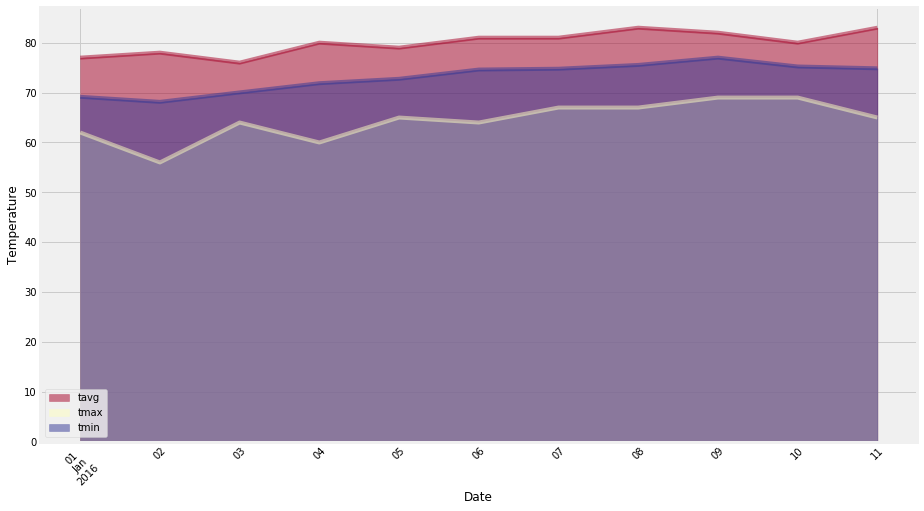

In [166]:
# Plot the daily normals as an area plot with `stacked=False`
date_df.plot.area(stacked = False, colormap='RdYlBu', rot=45,figsize=(14,8))
plt.ylabel("Temperature")
plt.xlabel('Date')

#plt.show()